In [1]:
#%load_ext autoreload
#%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import datetime

import datatable as dt

In [2]:
from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *
from fastai.tabular import * 


In [3]:
path = './'
TRAIN_FN = f'{path}train.feather'
TEST_FN  = f'{path}test.feather'

In [4]:
train_identity    = dt.fread(f'{path}train_identity.csv')
train_transaction = dt.fread(f'{path}train_transaction.csv')
train_identity.key = "TransactionID"
train = train_transaction[:, :, dt.join(train_identity)].to_pandas()
del train_identity, train_transaction

In [5]:
test_identity    = dt.fread(f'{path}test_identity.csv')
test_transaction = dt.fread(f'{path}test_transaction.csv')
test_identity.key = "TransactionID"
test = test_transaction[:, :, dt.join(test_identity)].to_pandas()
del test_identity, test_transaction

In [6]:
gc.collect()

34

try:
    assert False
    train = pd.read_feather(TRAIN_FN)
except:
    train_identity    = pd.read_csv(f'{path}train_identity.csv')
    train_transaction = pd.read_csv(f'{path}train_transaction.csv')
    train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
    train.to_feather(TRAIN_FN)
    del train_identity, train_transaction
    gc.collect()
    
try:
    assert False
    test = pd.read_feather(TEST_FN)
except:
    test_identity     = pd.read_csv(f'{path}test_identity.csv')
    test_transaction  = pd.read_csv(f'{path}test_transaction.csv')
    test  = pd.merge(test_transaction, test_identity,   on='TransactionID', how='left')
    test.to_feather(TEST_FN)
    del test_identity, test_transaction
    gc.collect()


In [7]:
train = pd.read_csv('./train_transaction.csv')
test  = pd.read_csv('./test_transaction.csv')

In [8]:
useful_features = list(train.iloc[:, 3:55].columns) + ['TransactionID', 'TransactionDT']

train = train[useful_features + ['isFraud']]
test = test[useful_features]

In [9]:
n_train = len(train)

In [10]:
test.insert(1,'isFraud', -100)

In [11]:
test_ids = test['TransactionID']

In [12]:
df = pd.concat([train, test], ignore_index= True,axis=0, sort=False)
n_test = len(df) - n_train
del train, test
gc.collect()
n_train, n_test

(590540, 506691)

# Processing

In [13]:
df

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,M3,M4,M5,M6,M7,M8,M9,TransactionID,TransactionDT,isFraud
0,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,T,M2,F,T,NaN,NaN,NaN,2987000,86400,0
1,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,NaN,M0,T,T,NaN,NaN,NaN,2987001,86401,0
2,59.000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,...,T,M0,F,F,F,F,F,2987002,86469,0
3,50.000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,...,NaN,M0,T,F,NaN,NaN,NaN,2987003,86499,0
4,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987004,86506,0
5,49.000,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,...,T,M1,F,T,NaN,NaN,NaN,2987005,86510,0
6,159.000,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,...,T,M0,F,F,T,T,T,2987006,86522,0
7,422.500,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,...,NaN,M0,F,F,NaN,NaN,NaN,2987007,86529,0
8,15.000,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987008,86535,0
9,117.000,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,...,T,M0,T,T,NaN,NaN,NaN,2987009,86536,0


In [14]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#579001
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

df['dow']   = df['TransactionDT'].dt.dayofweek
df['hour']  = df['TransactionDT'].dt.hour
df['day']   = df['TransactionDT'].dt.day

In [15]:
df = df.drop(['TransactionDT', 'TransactionID'], axis=1)

In [16]:
df['P_emaildomain'] = df['P_emaildomain'].fillna('na')
df['R_emaildomain'] = df['R_emaildomain'].fillna('na')

In [17]:
df['TransactionAmt_decimals'] = df['TransactionAmt'].map(lambda x:len(str(x).split('.')[1]))

In [18]:
cat_names = list(set(df.columns) - set(df._get_numeric_data().columns))

In [19]:
cat_names =  [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain',
    'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

In [20]:
procs = [FillMissing, Categorify, Normalize]
dep_var = 'isFraud'
cat_names = ['ProductCD', *[f'card{i}' for i in [1,2,3,4,5,6]], 'P_emaildomain', 'R_emaildomain', 'addr1','addr2',
             *[f'M{i}' for i in range(1,10)], 'DeviceType', 'DeviceInfo', 
             *[f'id_{i}' for i in range(12,39)], #[12,15,16,23,27,28,29,30,31,33,34,35,36,37,38]],
            'dow', 'hour', 'day']

In [21]:
cat_names = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain',
    'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

In [22]:
cont_names = list(np.setdiff1d(df.columns, cat_names + [dep_var]))

In [23]:
def diff_train_test(c):
    df[c] = df[c].fillna('na')
    df.loc[df[c].isnull(), c] = 'na'

for c in progress_bar(cat_names): diff_train_test(c)

In [24]:
min_threshold = 0.02

def frequency_encoding(c):
    encoding = df.groupby(c).size()/len(df)
    return df[c].map(encoding)
for c in progress_bar(np.setdiff1d(cat_names,['dow_freq','hour_freq','day_freq'])):
    df[f"{c}_freq"] = frequency_encoding(c)
    cont_names.append(f"{c}_freq")
    df[c][(frequency_encoding(c) <= min_threshold)] = f'm_{min_threshold}'

/home/antor/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [25]:
for c in progress_bar(cat_names):
    df[c] = df[c].astype('category').cat.codes

# LGB

In [26]:
import lightgbm as lgb


In [27]:
train_idx = range(int(n_train*.8))
valid_idx = list(np.setdiff1d(range(n_train), train_idx))

In [28]:
trn_data = lgb.Dataset(df.iloc[train_idx][cont_names + cat_names], label=df.iloc[train_idx]['isFraud'],
                      categorical_feature = cat_names)
val_data = lgb.Dataset(df.iloc[valid_idx][cont_names + cat_names], label=df.iloc[valid_idx]['isFraud'],
                      categorical_feature = cat_names)
#clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)


In [29]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }


In [30]:
clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], 
                verbose_eval=1000, early_stopping_rounds=500)


/home/antor/miniconda3/lib/python3.7/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/antor/miniconda3/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.993955	valid_1's auc: 0.923083
Early stopping, best iteration is:
[1390]	training's auc: 0.997499	valid_1's auc: 0.924265


# Tabular NN

In [31]:
for c in progress_bar(cat_names):
    df[c] = df[c].astype('category')

In [32]:
for c in cont_names:
    print(c, pd.isna(df[c]))

C1 0          False
1          False
2          False
3          False
4          False
           ...  
1097226    False
1097227    False
1097228    False
1097229    False
1097230    False
Name: C1, Length: 1097231, dtype: bool
C10 0          False
1          False
2          False
3          False
4          False
           ...  
1097226    False
1097227    False
1097228    False
1097229    False
1097230    False
Name: C10, Length: 1097231, dtype: bool
C11 0          False
1          False
2          False
3          False
4          False
           ...  
1097226    False
1097227    False
1097228    False
1097229    False
1097230    False
Name: C11, Length: 1097231, dtype: bool
C12 0          False
1          False
2          False
3          False
4          False
           ...  
1097226    False
1097227    False
1097228    False
1097229    False
1097230    False
Name: C12, Length: 1097231, dtype: bool
C13 0          False
1          False
2          False
3          False
4     

In [45]:
data = TabularDataBunch.from_df(path, df[:n_train], dep_var, cat_names=cat_names, 
                                cont_names =cont_names,
                                valid_idx=valid_idx, 
                                procs=[Normalize, FillMissing, Categorify])

In [46]:
data.batch_size = 4096*8

In [47]:
learn = tabular_learner(
    data, layers=[512]*32,
    ps=0.3,metrics=[accuracy, AUROC()], callback_fns=ShowGraph, use_bn=True)


In [48]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [4]                  24         True      
______________________________________________________________________
Embedding            [4]                  20         True      
______________________________________________________________________
Embedding            [6]                  72         True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [5]                  45         True      
______________________________________________________________________
Embedding            [3]                  12         True      
_________________________________________________

In [49]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(5, 4)
    (2): Embedding(12, 6)
    (3): Embedding(4, 3)
    (4): Embedding(4, 3)
    (5): Embedding(9, 5)
    (6): Embedding(4, 3)
    (7): Embedding(17, 8)
    (8): Embedding(4, 3)
    (9): Embedding(8, 5)
    (10): Embedding(6, 4)
    (11): Embedding(4, 3)
    (12): Embedding(4, 3)
    (13): Embedding(4, 3)
    (14): Embedding(5, 4)
    (15): Embedding(4, 3)
    (16): Embedding(4, 3)
    (17): Embedding(4, 3)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(3, 3)
    (27): Embedding(3, 3)
    (28): Embedding(3, 3)
    (29): Embedding(3, 3)
    (30): Embedding(3, 3)
    (31): Embedding(3, 3)
    (32): Embedding(3, 3)
    (33): Embedding(3, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
    (36): Embedding(3, 3)
  )
  (e

In [50]:
weight = Tensor(n_train / (2 * np.bincount(df['isFraud'][:n_train].values)))
learn.loss_func.weight=weight

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 2.51E-02


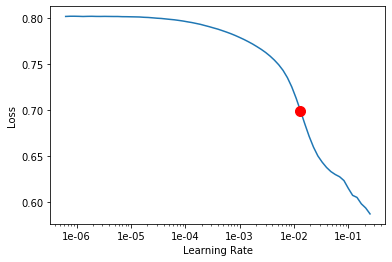

In [51]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10,5.75e-3)

In [52]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.reduction = reduction

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.reduction == 'mean': return loss.mean()
        else: return loss

In [53]:
class ThresholdLoss(Module):
    def __init__(self, pct=0.2, weight=None): 
        self.pct = pct
        self.loss = FocalLoss(reduction='none')
    def forward(self, from_forward, t_fraud):
        p_fraud = from_forward
        loss = self.loss(p_fraud, t_fraud)
        threshold = loss.topk(int(self.pct*len(t_fraud)))[0][-1]
        loss[loss < threshold] == 0.
        return loss.mean()

In [54]:
learn.loss_func = FocalLoss() #ThresholdLoss(weight=weight)

In [55]:
learn.callbacks.append(ReduceLROnPlateauCallback(learn, monitor="train_loss", patience=2))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.012159,0.033783,0.940156,0.781418,00:11
1,0.024834,1993.923218,0.965447,0.498221,00:11
2,0.025545,4.686447,0.965591,0.459779,00:11
3,0.024756,0.021507,0.965591,0.704234,00:11
4,0.023837,0.021096,0.965591,0.737499,00:11
5,0.023161,0.020385,0.965591,0.743726,00:11
6,0.022654,0.020039,0.965591,0.751105,00:10
7,0.022247,0.020040,0.965591,0.752300,00:10
8,0.021922,0.020006,0.965591,0.751870,00:10
9,0.021702,0.020015,0.965591,0.752062,00:11


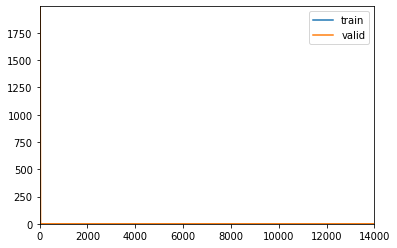

Epoch 3: reducing lr to 0.0024000000000000002
Epoch 6: reducing lr to 0.00048000000000000007
Epoch 9: reducing lr to 9.600000000000002e-05
Epoch 12: reducing lr to 1.9200000000000006e-05
Epoch 15: reducing lr to 3.840000000000001e-06
Epoch 18: reducing lr to 7.680000000000003e-07
Epoch 21: reducing lr to 1.5360000000000008e-07
Epoch 24: reducing lr to 3.072000000000002e-08
Epoch 27: reducing lr to 6.1440000000000044e-09
Epoch 30: reducing lr to 1.228800000000001e-09
Epoch 33: reducing lr to 2.457600000000002e-10
Epoch 36: reducing lr to 4.915200000000004e-11
Epoch 39: reducing lr to 9.83040000000001e-12
Epoch 42: reducing lr to 1.966080000000002e-12
Epoch 45: reducing lr to 3.9321600000000043e-13
Epoch 48: reducing lr to 7.864320000000009e-14
Epoch 51: reducing lr to 1.5728640000000017e-14
Epoch 54: reducing lr to 3.1457280000000035e-15
Epoch 57: reducing lr to 6.291456000000008e-16
Epoch 60: reducing lr to 1.2582912000000015e-16
Epoch 63: reducing lr to 2.516582400000003e-17
Epoch 66:

Epoch 513: reducing lr to 3.5917864239044595e-122
Epoch 516: reducing lr to 7.18357284780892e-123
Epoch 519: reducing lr to 1.436714569561784e-123
Epoch 522: reducing lr to 2.873429139123568e-124
Epoch 525: reducing lr to 5.746858278247136e-125
Epoch 528: reducing lr to 1.1493716556494273e-125
Epoch 531: reducing lr to 2.2987433112988547e-126
Epoch 534: reducing lr to 4.59748662259771e-127
Epoch 537: reducing lr to 9.19497324519542e-128
Epoch 540: reducing lr to 1.838994649039084e-128
Epoch 543: reducing lr to 3.6779892980781684e-129
Epoch 546: reducing lr to 7.355978596156338e-130
Epoch 549: reducing lr to 1.4711957192312676e-130
Epoch 552: reducing lr to 2.942391438462535e-131
Epoch 555: reducing lr to 5.884782876925071e-132
Epoch 558: reducing lr to 1.1769565753850142e-132
Epoch 561: reducing lr to 2.3539131507700286e-133
Epoch 564: reducing lr to 4.707826301540058e-134
Epoch 567: reducing lr to 9.415652603080116e-135
Epoch 570: reducing lr to 1.8831305206160234e-135
Epoch 573: redu

In [57]:
learn.fit(1000,1.2e-2)

In [ ]:
preds,y,losses = learn.get_preds(DatasetType.Fix,with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [ ]:
interp.top_losses(40000)

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(losses)

In [ ]:
interp.top_losses(len(preds))

# Autoencoder

In [ ]:
from fastai.tabular.transform import *

In [ ]:
cont_names = list(np.setdiff1d(cont_names, [c for c in cont_names if c.startswith('V')]))

In [ ]:
cat_names = list(np.setdiff1d(cat_names, ['DeviceInfo', 'DeviceType']))

In [ ]:
c = Categorify(cat_names, cont_names)
c.apply_train(df)

In [ ]:
cat_names

In [ ]:
cats = [LongTensor(df[cat_name].cat.codes.values) for cat_name in cat_names]


In [ ]:
cats = torch.cat([cat.unsqueeze(-1) for cat in cats], dim=-1)

In [ ]:
conts = [torch.log1p(Tensor(df[cont_name].values-df[cont_name].min())) for cont_name in cont_names]
for cont in conts: cont[cont!=cont] = -1 # turn NaNs into -1
conts = torch.cat([cont.unsqueeze(-1) for cont in conts], dim=-1)

In [ ]:
conts[0]

In [ ]:
conts.shape

In [ ]:
conts_mean, conts_std = conts.mean(dim=0), conts.std(dim=0)

In [ ]:
conts = (conts - conts_mean) / conts_std

In [ ]:
class TransactionItem(ItemBase):
    def __init__(self,i): self.i = i
    @property
    def data(self):
        return cats[self.i], conts[self.i]
    def __str__(self): return f'{self.i}'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        for t in tfms:
            if t: x.data = t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i)
    
    def reconstruct(self, t:Tensor, x:Tensor=None):
        return t

class TransactionItemList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def get(self, i):
        return super().get(i)

    def reconstruct(self,t): return 0; # TODO for viz !!!! ScalarCouplingItem(t.numpy())

In [ ]:
conts.shape

In [ ]:
data = ItemList(items=(TransactionItem(i) for i in range(conts.shape[0])))#,label_cls=TransactionItem)

In [ ]:
train_idx = range(int(n_train*.8))
valid_idx = list(np.setdiff1d(range(n_train), train_idx))

In [ ]:
data = data.split_by_idxs(train_idx, valid_idx)

In [ ]:
#data = data.label_from_func(func=lambda x:x,label_cls=TransactionItemList)
data = data.label_from_lists(df['isFraud'].values[train_idx], df['isFraud'].values[valid_idx])

In [ ]:
data=data.databunch()

In [ ]:
data.add_test(ItemList(items=(TransactionItem(i) for i in range(n_train,n_train+n_test))))

In [ ]:
data

In [ ]:
data

In [ ]:
torch.manual_seed(0)
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()

learner = tabular_learner(data,[128,64,32]).to_fp32()

## Model

In [ ]:
def emb_sz_rule(n_cat:int)->int: return min(50, (n_cat//2)+1)
flatten = lambda l: [item for sublist in l for item in sublist]

class TransactionAutoencoder(Module):
    def __init__(self, cat_names, cont_names,encoder_layers,decoder_layers=None):
        self.cat_names, self.cont_names = cat_names, cont_names
        self.cats_nunique  = cats.max(dim=0)[0]+1
        self.cat_embs = nn.ModuleList(
            [nn.Embedding(cat_nunique,emb_sz_rule(cat_nunique)) for cat_nunique in self.cats_nunique])
        self.emb_total_dim = sum([emb_sz_rule(cat_nunique) for cat_nunique in self.cats_nunique])
        self.cont_total_dim = conts.shape[1]
        decoder_layers=ifnone(decoder_layers, encoder_layers[::-1])
        encoder_layers.insert( 0,int(self.cont_total_dim + self.emb_total_dim))
        decoder_layers.append(int(self.cont_total_dim + self.cats_nunique.sum()))
        self.encoder = nn.Sequential(
            *flatten([[nn.Linear(encoder_layers[i],encoder_layers[i+1]),nn.ReLU(), nn.BatchNorm1d(encoder_layers[i+1])]
              for i in range(len(encoder_layers)-1)])[:])
        self.decoder = nn.Sequential(
            *flatten([[nn.Linear(decoder_layers[i],decoder_layers[i+1]),nn.ReLU(), nn.BatchNorm1d(decoder_layers[i+1])]
              for i in range(len(decoder_layers)-1)])[:-2])

    def forward(self,x_cats,x_conts):
        _x_cats = [x_cats[:,i] for i in range(x_cats.shape[1])]
        x = torch.cat([cat_emb(cat) for cat_emb,cat in zip(self.cat_embs, _x_cats)], dim=-1)
        x = torch.cat([x, x_conts], dim=-1)
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x[:,:self.cats_nunique.sum()],x[:,self.cats_nunique.sum():],latent
        

In [ ]:
class ReconstructionLoss(Module):
    def __init__(self, cats_nunique):
        self.cats_nunique = cats_nunique

    def forward(self, from_forward, t_cats, t_conts):
        p_cats, p_conts, _ = from_forward
        cat_loss = 0
        s_hot = e_hot = 0
        for i, n_hot in enumerate(self.cats_nunique):
            e_hot = s_hot + n_hot
            cat_loss += nn.CrossEntropyLoss()(p_cats[:,s_hot:e_hot], t_cats[:,i])
            s_hot = e_hot
        cat_loss /= i
        cont_loss = nn.MSELoss()(p_conts, t_conts)
        return cat_loss + cont_loss

In [ ]:
d_latent = 64


In [ ]:
torch.manual_seed(0)
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()

encoder_layers=[256,128,d_latent]
decoder_layers=encoder_layers[::-1]+[1024,2048]
net = TransactionAutoencoder(cat_names, cont_names,encoder_layers,decoder_layers)
learner = Learner(data,net,loss_func=ReconstructionLoss(net.cats_nunique),callback_fns=ShowGraph).to_fp32()

In [ ]:
learner.summary()

In [ ]:
learner.model

In [ ]:
data.batch_size = 4096*8

In [ ]:
autoencoder_fname = 'autoencoder_loss0.0008val0.0010'

In [ ]:
loaded = False
try:
    learner.load(autoencoder_fname, strict=False)
    loaded = True
except Exception as e:
    print(e)

In [ ]:
if not loaded:
    learner.lr_find()
    learner.recorder.plot(suggestion=True)

In [ ]:
if not loaded: learner.fit_one_cycle(100,1.4e-3)

In [ ]:
val = learner.validate()[0]
val

In [ ]:
if not loaded:
    try:
        autoencoder_fname = f'autoencoder_loss{learner.recorder.losses[-1]:.04f}val{val:.04f}'
    except:
        autoencoder_fname = f'autoencoder_lossval{val:.04f}'
    learner.save(autoencoder_fname)
    print(autoencoder_fname)

In [ ]:
learner.data.fix_dl.batch_size = data.batch_size

In [ ]:
def get_latents(ds_type):
    latents = torch.empty(0,d_latent)
    for batch_idx, batch in progress_bar(
        enumerate(learner.dl(ds_type)), total=len(learner.dl(ds_type))):
            _, _, latent = learner.pred_batch(ds_type=DatasetType.Train, batch=batch)
            latents = torch.cat([latents, latent], dim = 0)
    return latents
            
latents      = get_latents(DatasetType.Fix)
latents_test = get_latents(DatasetType.Test)

In [ ]:
learner.data.train_ds[0][0].data, learner.data.train_ds[0][1].data

In [ ]:
(x, y, pred, raw_pred) = learner.predict(learner.data.train_ds[0][0], return_x=True)
p_cat, p_cont, _ = raw_pred

In [ ]:
print('x', x)
print('raw_pred', raw_pred)
print(p_cat[:10])

In [ ]:
df_latent = pd.DataFrame({**{'isFraud': df['isFraud'][:n_train].values.astype(np.int32)},
                          **{f'l_{i}' : latents[:n_train,i].cpu().numpy().T for i in range(d_latent)}})

In [ ]:
df_latent

In [ ]:
df_latent_test = pd.DataFrame({**{f'l_{i}' : latents_test[:,i].cpu().numpy().T for i in range(d_latent)}})

# Classifier

In [ ]:
data = TabularDataBunch.from_df(path, df_latent, dep_var, cat_names=None, 
                                cont_names = [f'l_{i}' for i in range(d_latent)],
                                valid_idx=range(int(n_train*.8), n_train, 2), 
                                procs=[Normalize])

In [ ]:
learn = tabular_learner(
    data, layers=#[d_latent* 2]*4+[d_latent* 4]*4+[d_latent* 8]*4+[d_latent*  4]*4+[d_latent*2]*4+[d_latent*1]*4+
                 [d_latent//2]*4+[d_latent//4]*4+[d_latent//8]*4+[d_latent//16]*4,
                 #[d_latent//2]*1+[d_latent//4]*1+[d_latent//8]*1+[d_latent//16]*1,
    ps=0,metrics=[accuracy, AUROC()], callback_fns=ShowGraph, use_bn=True)


In [ ]:
learn.loss_func = FocalLoss(gamma=2., alpha=.25)
#learn.loss_func.weight=Tensor(n_train / (2 * np.bincount(df_latent['isFraud'].values)))

In [ ]:
learn.loss_func.weight

In [ ]:
learn.model

In [ ]:
learn.summary()

In [ ]:
learn.data.batch_size = 4096

In [ ]:
#classifier_fname = 'classifier_loss0.0731val0.8956'

In [ ]:
loaded = False
try:
    learn.load(classifier_fname, strict=False)
    loaded = True
except Exception as e:
    print(e)

In [ ]:
if not loaded:
    learn.lr_find()
    learn.recorder.plot(suggestion=True)

In [ ]:
if not loaded: learn.fit_one_cycle(100, 6e-2)

In [ ]:
cv = learn.validate()[2]
cv

In [ ]:
if not loaded:
    try:
        classifier_fname = f'classifier_loss{learn.recorder.losses[-1]:.04f}val{cv:.04f}'
    except:
        classifier_fname = f'classifier_val{cv:.04f}'
    learn.save(classifier_fname)
    print(classifier_fname)

# Predictions

In [ ]:
df_latent_test.shape

In [ ]:
learn.data.add_test(TabularList.from_df(df_latent_test, cat_names=None))

In [ ]:
learn.data

In [ ]:
preds = learn.get_preds(DatasetType.Test)

In [ ]:
len(preds[0])

In [ ]:
sub_df = pd.DataFrame({'TransactionID' : test_ids, 'isFraud' : preds[0][:,1]})
sub_df.head()

In [ ]:
csv_fname = f'cv{cv}.csv'
sub_df.to_csv(csv_fname, index=False)

In [ ]:
comp = 'ieee-fraud-detection'
!kaggle competitions submit -c {comp} -f {csv_fname} -m '{cv}'